# Airfoil Self-Noise - Noise Detection Benchmark (v2)

## Goal
Benchmark GGH as a noise detection method on the Airfoil Self-Noise dataset.

## Challenge
- **Simulated noise**: 40% of target values corrupted (range 0.4-0.6 around mean)
- **Unsupervised**: No labeled clean samples available during detection
- **Evaluation only**: Ground truth labels used only to measure detection performance

## Methods Compared
1. **Full Info (No Noise)**: Oracle upper bound - trained on clean data
2. **Full Info Noisy**: Baseline - trained on noisy data without removal
3. **Old GGH (DBSCAN)**: Gradient extraction + DBSCAN clustering + retrain on cleaned data

In [1]:
# CUDA determinism fix (must be before torch import)
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import numpy as np
import torch
import sys
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, '../')
sys.path.insert(0, '../GGH')

from GGH.data_ops import DataOperator
from GGH_2.noise_detection import (
    set_to_deterministic,
    run_full_info,
    run_full_info_noisy,
    run_old_ggh_dbscan,
    run_old_ggh_dbscan_fast,
)
from GGH_2.noise_detection_viz import plot_all_noise_detection_metrics
from GGH_2.benchmark_viz import save_noise_detection_results, load_noise_detection_results

print('Imports successful!')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

Imports successful!
Using device: cpu


In [2]:
# =============================================================================
# CONFIGURATION - Airfoil Self-Noise Dataset
# =============================================================================
data_path = '../data/airfoil_self_noise/data.csv'
results_path = '../saved_results/Airfoil_Noise_Detection_v2'

# Variables (all features as inputs for noise detection)
inpt_vars = ['frequency', 'attack-angle', 'free-stream-velocity',
             'suction-side-displacement-thickness', 'chord-length']
target_vars = ['scaled-sound-pressure']
miss_vars = []
hypothesis = [[1, 2, 3]]

# Model parameters
hidden_size = 32
dropout = 0.05
lr = 0.001

# Noise simulation parameters
DATA_NOISE_PERC = 0.40  # 40% of data will have noise
NOISE_MINRANGE = 0.40   # Noise factor range
NOISE_MAXRANGE = 0.60
noise_profile = {
    'DATA_NOISE_PERC': DATA_NOISE_PERC,
    'NOISE_MINRANGE': NOISE_MINRANGE,
    'NOISE_MAXRANGE': NOISE_MAXRANGE
}

# Training parameters
partial_perc = 0.03
batch_size = 250

# Benchmark parameters
BENCHMARK_N_RUNS = 15
FULL_INFO_EPOCHS = 600
NOISY_EPOCHS = 600

# Old GGH (DBSCAN) parameters
INCLUDE_OLD_GGH_ORIGINAL = False  # Set to True to also run the slow original variant
OLD_GGH_EPOCHS = 585
OLD_GGH_END_EPOCHS = 15
OLD_GGH_EPS_VALUES = [0.15, 0.2]
OLD_GGH_MIN_SAMPLES_RATIOS = [0.15, 0.2, 0.25]
GGH_FINAL_EPOCHS = 600

# Shared config dict for noise detection functions
nd_config = {
    'data_path': data_path,
    'inpt_vars': inpt_vars,
    'target_vars': target_vars,
    'miss_vars': miss_vars,
    'hypothesis': hypothesis,
    'partial_perc': partial_perc,
    'batch_size': batch_size,
    'hidden_size': hidden_size,
    'lr': lr,
    'dropout': dropout,
    # Noise simulation
    'noise_perc': DATA_NOISE_PERC,
    'noise_min': NOISE_MINRANGE,
    'noise_max': NOISE_MAXRANGE,
    # Old GGH
    'old_ggh_epochs': OLD_GGH_EPOCHS,
    'old_ggh_end_epochs': OLD_GGH_END_EPOCHS,
    'old_ggh_eps_values': OLD_GGH_EPS_VALUES,
    'old_ggh_min_samples_ratios': OLD_GGH_MIN_SAMPLES_RATIOS,
    'final_epochs': GGH_FINAL_EPOCHS,
}

os.makedirs(results_path, exist_ok=True)

print(f'Dataset: Airfoil Self-Noise')
print(f'Noise simulation: {DATA_NOISE_PERC*100}% of data, range [{NOISE_MINRANGE}, {NOISE_MAXRANGE}]')
print(f'Benchmark runs: {BENCHMARK_N_RUNS}')
print(f'Results path: {results_path}')
print(f'Include original Old GGH (slow): {INCLUDE_OLD_GGH_ORIGINAL}')

Dataset: Airfoil Self-Noise
Noise simulation: 40.0% of data, range [0.4, 0.6]
Benchmark runs: 15
Results path: ../saved_results/Airfoil_Noise_Detection_v2
Include original Old GGH (slow): False


## Main Benchmark

Run all methods across multiple random seeds:
1. **Full Info (No Noise)** - Oracle upper bound
2. **Full Info Noisy** - Baseline with noise, no removal
3. **Old GGH (DBSCAN)** - Gradient extraction + DBSCAN clustering + retrain on cleaned data

In [3]:
# =============================================================================
# BENCHMARK EXECUTION
# =============================================================================
print('=' * 80)
print('BENCHMARK: Noise Detection on Airfoil Self-Noise')
print('=' * 80)

all_results = {
    'Full Info': [],
    'Full Info Noisy': [],
    'Old GGH (DBSCAN)': [],
}
if INCLUDE_OLD_GGH_ORIGINAL:
    all_results['Old GGH (Original)'] = []

for run_idx in range(BENCHMARK_N_RUNS):
    r_state = run_idx
    print(f'\n--- RUN {run_idx + 1}/{BENCHMARK_N_RUNS} (r_state={r_state}) ---')

    # Create DO with noise for this run
    set_to_deterministic(r_state)
    DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis,
                      partial_perc, r_state, device='cpu', use_case='noise detection')
    DO.simulate_noise(DATA_NOISE_PERC, NOISE_MINRANGE, NOISE_MAXRANGE)

    n_total = len(DO.df_train_noisy)
    n_noisy = DO.df_train_noisy['noise_added'].sum()
    print(f'  True noisy: {n_noisy}/{n_total} ({n_noisy/n_total*100:.1f}%)')

    # --- Full Info (No Noise) ---
    print('  Running Full Info (no noise)...')
    set_to_deterministic(r_state)
    DO_clean = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis,
                            partial_perc, r_state, device='cpu', use_case='noise detection')
    full_result = run_full_info(DO_clean, r_state, batch_size, hidden_size, lr,
                                FULL_INFO_EPOCHS, dropout, results_path)
    all_results['Full Info'].append(full_result)
    print(f'    R2: {full_result["test_r2"]:.4f}')

    # --- Full Info Noisy (Baseline) ---
    print('  Running Full Info Noisy (baseline)...')
    noisy_result = run_full_info_noisy(DO, r_state, batch_size, hidden_size, lr,
                                       NOISY_EPOCHS, dropout, results_path)
    all_results['Full Info Noisy'].append(noisy_result)
    print(f'    R2: {noisy_result["test_r2"]:.4f}')

    # --- Old GGH (DBSCAN) - Fast variant (default) ---
    print('  Running Old GGH (DBSCAN)...')
    old_result = run_old_ggh_dbscan_fast(DO, r_state, nd_config)
    all_results['Old GGH (DBSCAN)'].append(old_result)
    print(f'    R2: {old_result["test_r2"]:.4f}, '
          f'Detection P/R: {old_result["detection"]["precision"]:.3f}/{old_result["detection"]["recall"]:.3f}')

    # --- Old GGH (Original) - Optional slow variant ---
    if INCLUDE_OLD_GGH_ORIGINAL:
        print('  Running Old GGH (Original, slow)...')
        set_to_deterministic(r_state)
        DO_orig = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis,
                               partial_perc, r_state, device='cpu', use_case='noise detection')
        DO_orig.simulate_noise(DATA_NOISE_PERC, NOISE_MINRANGE, NOISE_MAXRANGE)
        old_orig_result = run_old_ggh_dbscan(DO_orig, r_state, nd_config)
        all_results['Old GGH (Original)'].append(old_orig_result)
        print(f'    R2: {old_orig_result["test_r2"]:.4f}, '
              f'Detection P/R: {old_orig_result["detection"]["precision"]:.3f}/{old_orig_result["detection"]["recall"]:.3f}')

print(f'\n{"=" * 80}')
print('BENCHMARK COMPLETE')
print(f'{"=" * 80}')

# Save results to disk
save_noise_detection_results(all_results, 'Airfoil Self-Noise', results_path,
                             noise_profile=noise_profile)

BENCHMARK: Noise Detection on Airfoil Self-Noise

--- RUN 1/15 (r_state=0) ---
  True noisy: 432/1082 (39.9%)
  Running Full Info (no noise)...
    R2: 0.7951
  Running Full Info Noisy (baseline)...
    R2: 0.5802
  Running Old GGH (DBSCAN)...
    R2: 0.7662, Detection P/R: 0.996/0.558

--- RUN 2/15 (r_state=1) ---
  True noisy: 432/1082 (39.9%)
  Running Full Info (no noise)...
    R2: 0.8561
  Running Full Info Noisy (baseline)...
    R2: 0.5643
  Running Old GGH (DBSCAN)...
    R2: 0.8225, Detection P/R: 0.984/0.565

--- RUN 3/15 (r_state=2) ---
  True noisy: 432/1082 (39.9%)
  Running Full Info (no noise)...
    R2: 0.8595
  Running Full Info Noisy (baseline)...
    R2: 0.5920
  Running Old GGH (DBSCAN)...
    R2: 0.8526, Detection P/R: 0.943/0.963

--- RUN 4/15 (r_state=3) ---
  True noisy: 432/1082 (39.9%)
  Running Full Info (no noise)...
    R2: 0.8064
  Running Full Info Noisy (baseline)...
    R2: 0.6399
  Running Old GGH (DBSCAN)...
    R2: 0.7084, Detection P/R: 0.961/0.972

'../saved_results/Airfoil_Noise_Detection_v2/Airfoil_Self-Noise_noise_results_2026-02-11.json'

In [4]:
# =============================================================================
# LOAD RESULTS (use this cell instead of running the benchmark above)
# =============================================================================
import glob

result_files = sorted(glob.glob(os.path.join(results_path, 'Airfoil_Self-Noise_noise_results_*.json')))
if not result_files:
    raise FileNotFoundError(f"No saved results found in {results_path}")

latest_file = result_files[-1]
all_results, metadata = load_noise_detection_results(latest_file)

Loaded results: Airfoil Self-Noise (2026-02-11 12:05:04)
  15 runs, 3 methods: ['Full Info', 'Full Info Noisy', 'Old GGH (DBSCAN)']


## Results Summary

In [5]:
# =============================================================================
# SUMMARY TABLE
# =============================================================================
print('\n' + '=' * 90)
print('RESULTS SUMMARY')
print('=' * 90)

print(f'\n{"Method":<25} {"R2":>10} {"MSE":>12} {"MAE":>12}')
print('-' * 60)

for method, results in all_results.items():
    r2_list = [r['test_r2'] for r in results]
    mse_list = [r['test_mse'] for r in results]
    mae_list = [r['test_mae'] for r in results]
    print(f'{method:<25} '
          f'{np.mean(r2_list):>6.4f} +/- {np.std(r2_list):.4f}  '
          f'{np.mean(mse_list):.6f}  '
          f'{np.mean(mae_list):.6f}')

# Detection metrics for GGH methods
print(f'\n{"="*90}')
print('DETECTION METRICS')
print(f'{"="*90}')
print(f'{"Method":<25} {"Precision":>10} {"Recall":>10} {"F1":>10} {"Accuracy":>10}')
print('-' * 70)

detection_methods = [m for m in all_results if 'GGH' in m]
for method in detection_methods:
    results = all_results[method]
    precision = [r['detection']['precision'] for r in results]
    recall = [r['detection']['recall'] for r in results]
    f1 = [r['detection']['f1'] for r in results]
    accuracy = [r['detection']['accuracy'] for r in results]
    print(f'{method:<25} '
          f'{np.mean(precision):>6.3f}+/-{np.std(precision):.3f} '
          f'{np.mean(recall):>6.3f}+/-{np.std(recall):.3f} '
          f'{np.mean(f1):>6.3f}+/-{np.std(f1):.3f} '
          f'{np.mean(accuracy):>6.3f}+/-{np.std(accuracy):.3f}')

# Statistical tests
print(f'\n{"="*90}')
print('STATISTICAL TESTS (Paired t-test on R2)')
print(f'{"="*90}')

old_r2 = [r['test_r2'] for r in all_results['Old GGH (DBSCAN)']]
noisy_r2 = [r['test_r2'] for r in all_results['Full Info Noisy']]

t_stat, p_val = stats.ttest_rel(old_r2, noisy_r2)
diff = np.mean(old_r2) - np.mean(noisy_r2)
sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else ''
print(f'\nOld GGH vs Noisy: diff={diff:+.4f}, t={t_stat:.3f}, p={p_val:.4f} {sig}')


RESULTS SUMMARY

Method                            R2          MSE          MAE
------------------------------------------------------------
Full Info                 0.8364 +/- 0.0326  0.005493  0.054304
Full Info Noisy           0.6152 +/- 0.0486  0.012863  0.086422
Old GGH (DBSCAN)          0.7864 +/- 0.0585  0.007112  0.061063

DETECTION METRICS
Method                     Precision     Recall         F1   Accuracy
----------------------------------------------------------------------
Old GGH (DBSCAN)           0.955+/-0.029  0.878+/-0.143  0.906+/-0.081  0.933+/-0.049

STATISTICAL TESTS (Paired t-test on R2)

Old GGH vs Noisy: diff=+0.1712, t=9.207, p=0.0000 ***


## Visualizations

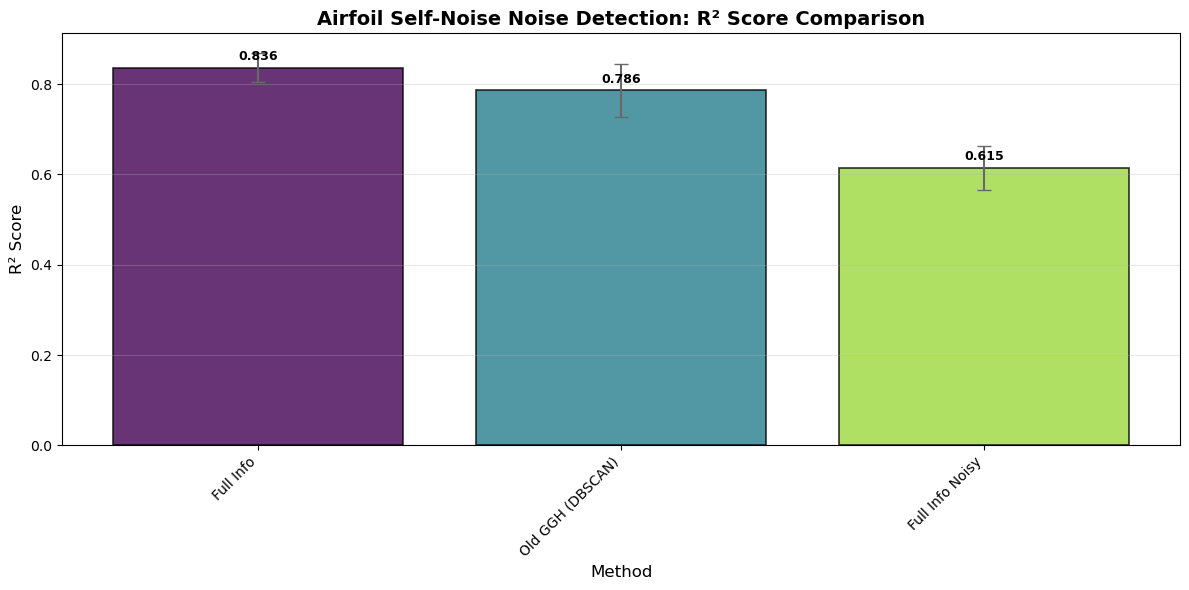

Plot saved to: ../saved_results/Airfoil_Noise_Detection_v2/Airfoil_Self-Noise_noise_r2_2026-02-11.png


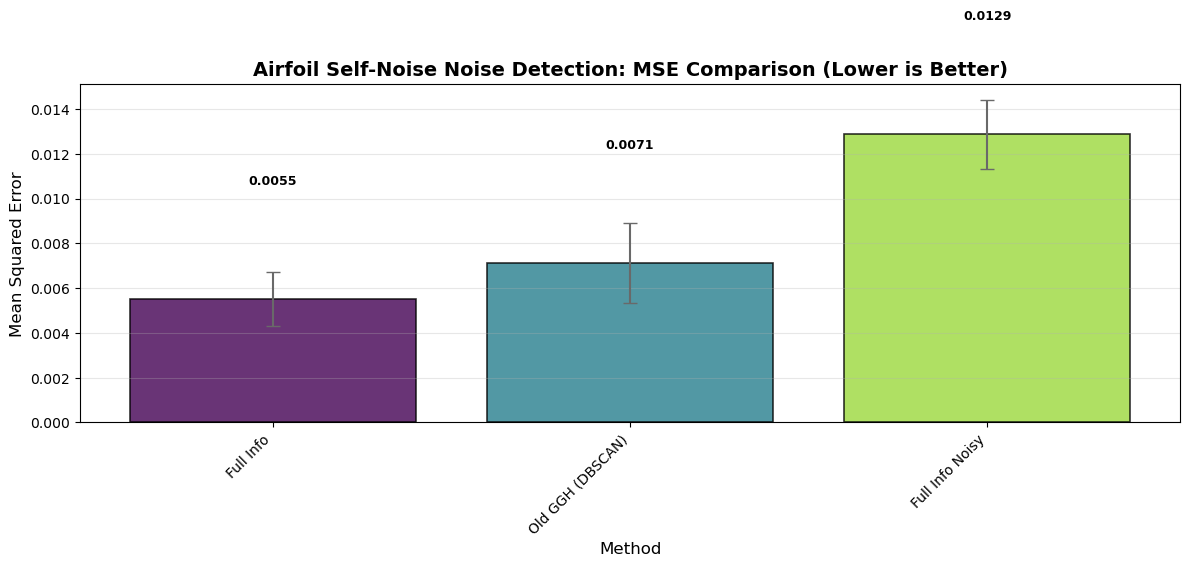

Plot saved to: ../saved_results/Airfoil_Noise_Detection_v2/Airfoil_Self-Noise_noise_mse_2026-02-11.png


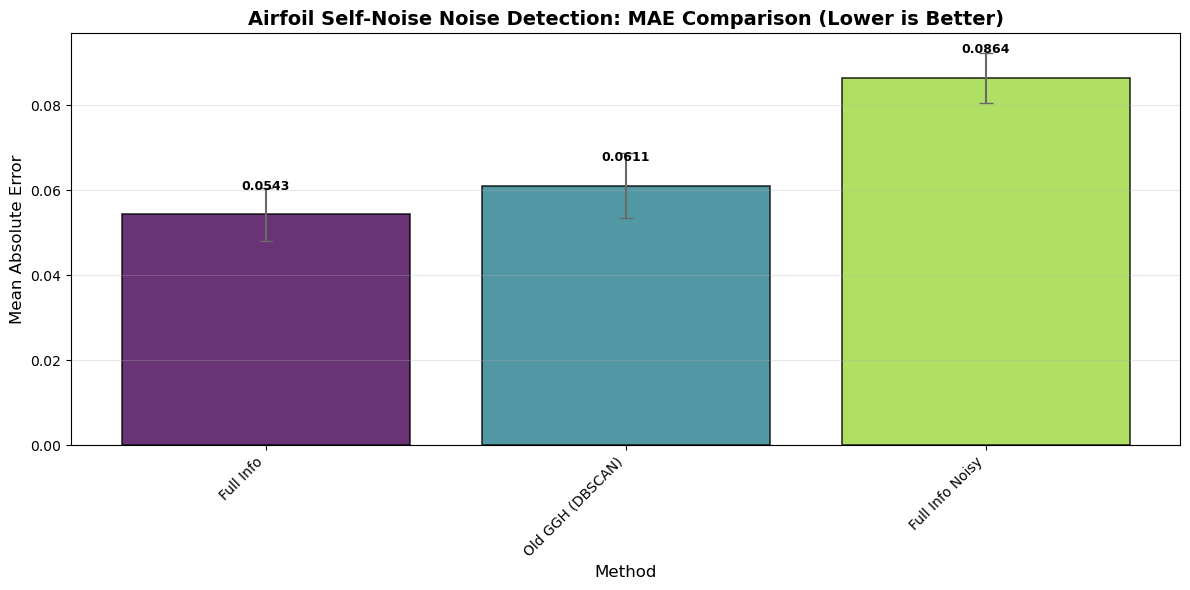

Plot saved to: ../saved_results/Airfoil_Noise_Detection_v2/Airfoil_Self-Noise_noise_mae_2026-02-11.png


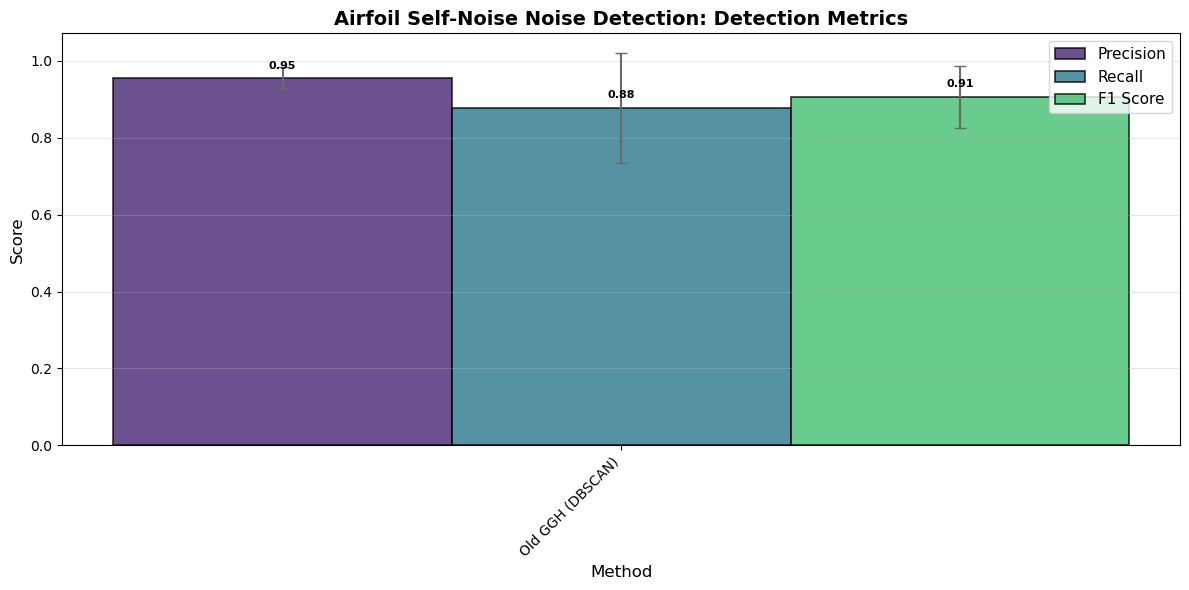

Plot saved to: ../saved_results/Airfoil_Noise_Detection_v2/Airfoil_Self-Noise_detection_metrics_2026-02-11.png


In [6]:
# =============================================================================
# VISUALIZATION: ALL METRICS
# =============================================================================
plot_all_noise_detection_metrics(all_results, 'Airfoil Self-Noise', results_path)